In [172]:
import os
import scipy.io as scio
import matplotlib.pyplot as plt
import numpy as np
from scipy.fftpack import fft,ifft
from scipy.signal import stft # 短时傅里叶变换
from matplotlib.pylab import mpl
import math
import pywt

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from tensorflow.keras.utils import to_categorical
from torch.utils.data import ConcatDataset
import torchvision.transforms as transforms
import torch.nn.functional as F
import random

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sb

from IPython.display import clear_output
mpl.rcParams['font.sans-serif'] = ['Times New Roman']

# 参数设置

In [26]:
batch_size = 20
CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda:1" if CUDA else "cpu")

EPOCHS = 60
LEARNING_RATE = 0.0001
# TEST_RATIO = 0.2

In [10]:
# 固定随机种子
def random_seed():
    torch.manual_seed(0)
    np.random.seed(0)
    random.seed(0)

    if CUDA:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        
random_seed()

# 构建数据集

In [3]:
path = "./data/" #⽂件夹⽬录
files =  os.listdir(path) #得到⽂件夹下的所有⽂件名

Data_X = [] # 数据
Data_Y = [] # 标签

for file in files:
    dataFile = path + file
    data = scio.loadmat(dataFile)
    Data_X.append(data['x'].squeeze())
    Data_Y.append(data['y'].squeeze())
    
Data_X = np.array(Data_X)
Data_Y = np.array(Data_Y)

/remote-home/cyzhang/miniconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  del sys.path[0]
/remote-home/cyzhang/miniconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [4]:
# 数据降噪

Data_X_denoise = []
for data in Data_X:
    tmp = []
    for j in range(len(data)):
        tmp.append(np.array(denoise(data[j])))
    Data_X_denoise.append(np.array(tmp))

In [22]:
# 思路1：直接把所有数据混合到一起，然后随机分出测试集和训练集
# 思路2：按82比，选择16个样本作为训练集，剩下的4个作为测试机（先实验这个）

# 训练集，测试集
X_train = np.concatenate(Data_X_denoise[0:16], axis = 0) # 16615
Y_train = np.concatenate(Data_Y[0:16], axis = 0).reshape(-1,1)
Y_train = to_categorical(Y_train, num_classes = 5)
X_test =  np.concatenate(Data_X_denoise[16:], axis = 0)
Y_test = np.concatenate(Data_Y[16:], axis = 0).reshape(-1,1)
Y_test = to_categorical(Y_test, num_classes = 5)

X_train.shape, Y_train.shape,X_test.shape, Y_test.shape

((16599, 3000), (16599, 5), (4441, 3000), (4441, 5))

In [50]:
# 构造一维数据集，按照如下方式

train_dataset = TensorDataset(torch.tensor(X_train, dtype = torch.float32).view(-1, 1, 1,3000), torch.tensor(Y_train))
test_dataset = TensorDataset(torch.tensor(X_test, dtype = torch.float32).view(-1, 1,1,3000), torch.tensor(Y_test))

train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

# 网络模型

In [128]:
# 用于一维数据分类的卷积神经网络
class ZCY_EEGNet(nn.Module):
    def __init__(self):
        super(ZCY_EEGNet, self).__init__()
        self.conv1 = nn.Conv1d(in_channels = 1, out_channels = 10, 
                               kernel_size = [1,200], stride = 2) # 10，1，1401
        self.max_pool1 = nn.MaxPool1d(kernel_size = 20, 
                                      stride = 2) # 10，1，691
        
        self.conv2 = nn.Conv1d(10, 100, [1, 20], [1,2]) # 100，1，336
        self.max_pool2 = nn.MaxPool1d(10, 2) # 164 
        
#         self.conv3 = nn.Conv1d(20, 40, 3, 2) # 100,
        self.liner1 = nn.Linear(100*164, 500)
        self.liner2 = nn.Linear(500, 500)
        self.liner3 = nn.Linear(500, 5) 
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = x.squeeze(dim = 2)
        x = self.max_pool1(x)
        x = x.unsqueeze(dim = 2)
        x = F.relu(self.conv2(x))
        x = x.squeeze(dim = 2)
        x = self.max_pool2(x)
        x = x.view(-1,100*164)
#         x = F.relu(self.conv3(x))
#         x = x.view(-1, 40 * 14)
        x = F.relu(self.liner1(x))
        x = F.relu(self.liner2(x))
        x = self.liner3(x)
        return x

In [129]:
from torchsummary import  summary

model_t = ZCY_EEGNet().cuda()
x = model_t(torch.randn(20,1,1,3000).cuda())
x.size()

summary(model_t, (1, 1, 3000))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1          [-1, 10, 1, 1401]           2,010
         MaxPool1d-2              [-1, 10, 691]               0
            Conv1d-3          [-1, 100, 1, 336]          20,100
         MaxPool1d-4             [-1, 100, 164]               0
            Linear-5                  [-1, 500]       8,200,500
            Linear-6                  [-1, 500]         250,500
            Linear-7                    [-1, 5]           2,505
Total params: 8,475,615
Trainable params: 8,475,615
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.55
Params size (MB): 32.33
Estimated Total Size (MB): 32.89
----------------------------------------------------------------


# 训练函数

In [24]:
# 训练函数
def train_model(model, train_loader, test_loader, optimizer, 
                criterion, epochs, device, save_path):
    
    min_train_loss = np.inf
    model = model.to(device)

    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(epochs):
        train_loss = 0
        test_loss = 0
        train_accuracy = 0
        test_accuracy = 0

        model.train()
        cnt = 0
        for batch in train_loader:
            cnt += 1 # 计数
            image_batch = batch[0].to(device)
            label_batch = batch[1].to(device)
            _, label_batch = torch.max(label_batch, 1)

            optimizer.zero_grad()
            y_pred = model(image_batch).to(device)
            batch_loss = criterion(y_pred, label_batch)
            batch_loss.backward()
            optimizer.step()

            _, output_labels = torch.max(y_pred, 1)
            correct = label_batch.eq(output_labels).cpu().numpy()
            train_accuracy += sum(correct)
            train_loss += batch_loss.item() * image_batch.size(0)
            
            # 实时显示训练过程
            print("epoch:{}, train:{}/{}".format(epoch, cnt, len(train_loader)))
            clear_output(wait = True)
            
        
        average_training_loss = train_loss / len(train_loader.sampler)
        average_training_accuracy = train_accuracy / len(train_loader.sampler)

        average_testing_loss, average_testing_accuracy, _, _ = test_model(
            model, test_loader, 
            criterion, device
            )    
    
        train_losses.append(average_training_loss)
        test_losses.append(average_testing_loss)
        train_accuracies.append(average_training_accuracy)
        test_accuracies.append(average_testing_accuracy)

        print('Epoch: {}/{} \t Train Loss: {:.6f} \t Test Loss: {:.6f} \t Train Accuracy: {:.4f} \t Test Accuracy: {:.4f}'
              .format(epoch,epochs, average_training_loss, average_testing_loss, average_training_accuracy, average_testing_accuracy))
    
        if min_train_loss > average_training_loss :
            print('Model improved - Saving Model')
            min_train_loss = average_training_loss
            torch.save(model.state_dict(), save_path)      
  
    return train_losses, test_losses, train_accuracies, test_accuracies

In [136]:
# 测试函数
def test_model(model, test_loader, criterion, device):
    model = model.to(device)
    test_accuracy = 0
    test_loss = 0
    true_labels = []
    pred_labels = []

    model.eval() # 进入评估模式
    cnt = 0
    for batch in test_loader:
        cnt += 1
        image_batch = batch[0].to(device)
        label_batch = batch[1].to(device)
        _, label_batch = torch.max(label_batch, 1)

        y_pred = model(image_batch)
        batch_loss = criterion(y_pred, label_batch)

        _, output_labels = torch.max(y_pred, 1)
        correct = label_batch.eq(output_labels).cpu().numpy()

        test_accuracy += sum(correct)
        test_loss += batch_loss.item() * image_batch.size(0)

        true_labels += list(label_batch.cpu().numpy())
        pred_labels += list(output_labels.cpu().numpy())
        
        # 实时显示测试过程
        print("test:{}/{}".format(cnt, len(test_loader)))
        clear_output(wait = True)

    average_testing_loss = test_loss / len(test_loader.sampler)
    average_testing_accuracy = test_accuracy / len(test_loader.sampler)
    return average_testing_loss, average_testing_accuracy, true_labels, pred_labels

# 开始训练并保存模型参数

In [344]:
model = ZCY_EEGNet()
model_name = "ZCY_EEGNet"
LABELS = ['Wake','N1','N2','N3','REM']
criterion = nn.CrossEntropyLoss() # 损失函数
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE)

save_path = "./Model/" + model_name + '_weights_' + str(LEARNING_RATE) + '_' +  '.pt'

In [348]:
train_losses, test_losses, train_accuracies, test_accuracies = train_model(
      model = model, 
      train_loader = train_loader, 
      test_loader = test_loader, 
      optimizer = optimizer, 
      criterion = criterion, 
      epochs = EPOCHS, 
      device = DEVICE,
      save_path = save_path
      )

clear_output(wait=True)

Epoch: 59/60 	 Train Loss: 0.391305 	 Test Loss: 0.615029 	 Train Accuracy: 0.8543 	 Test Accuracy: 0.7766
Model improved - Saving Model


In [161]:
# 保存训练过程
save_pth = "./TrainingProcess/ZCY_EEGNet/"
np.savetxt(save_pth + "train_losses.txt", train_losses)
np.savetxt(save_pth + "test_losses.txt", test_losses)
np.savetxt(save_pth + "train_accuracies.txt", train_accuracies)
np.savetxt(save_pth + "test_accuracies.txt", test_accuracies)

# 测试模型

In [163]:
model_test = ZCY_EEGNet()
model_test.eval()
model_test.load_state_dict(torch.load("./Model/ZCY_EEGNet_weights_0.0001_.pt"))

<All keys matched successfully>

In [164]:
# 测试函数
avg_test_loss, avg_test_acc, true_labels, pred_labels = test_model(model_test, test_loader, criterion, DEVICE)
print(avg_test_acc)

0.787210087818059


In [181]:
# 注意：准确性、敏感性（召回率）、特异性、F1-score(精准率和召回率的调和平均数)

print(classification_report(true_labels, pred_labels, target_names=LABELS))

              precision    recall  f1-score   support

        Wake       0.80      0.93      0.86       818
          N1       0.46      0.18      0.26       331
          N2       0.81      0.88      0.84      1851
          N3       0.91      0.80      0.85       682
         REM       0.67      0.67      0.67       759

    accuracy                           0.79      4441
   macro avg       0.73      0.69      0.70      4441
weighted avg       0.77      0.79      0.77      4441



In [234]:
# 特异性
from torchmetrics import Specificity

test_spc_en = Specificity(num_classes=5, threshold=1. / 5, average="macro") # Specificity
print(test_spc_en(torch.tensor(pred_labels), torch.tensor(true_labels)))

tensor(0.9403)


In [176]:
def plot_confusion_matrix(y_true, y_pred, filename):
    sb.set(font_scale=1.5)
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 10))
    sb.heatmap(cm, annot=True, fmt="d", linewidths=5, 
               xticklabels=LABELS, yticklabels=LABELS,
               cmap="Blues")
    plt.show()

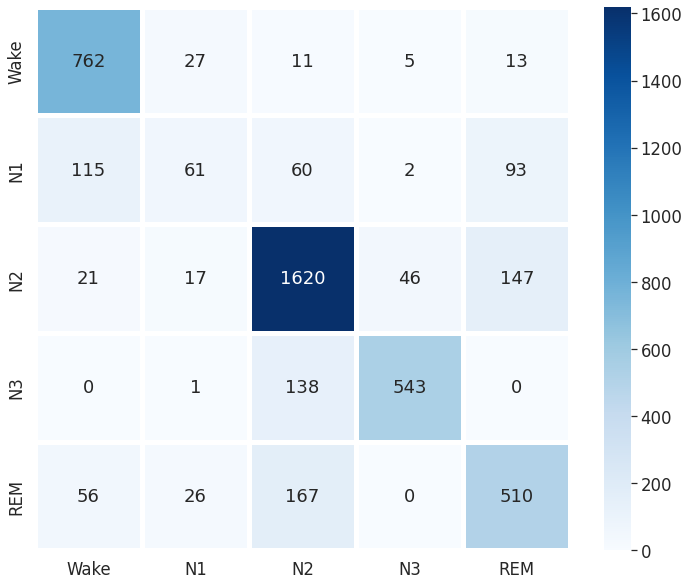

In [177]:
plot_confusion_matrix(true_labels, pred_labels, "")

# ZCY-EEGNet-T

In [214]:
# 用于一维数据分类的卷积神经网络
class ZCY_EEGNet_T(nn.Module):
    def __init__(self):
        super(ZCY_EEGNet_T, self).__init__()
        self.conv1 = nn.Conv1d(in_channels = 1, out_channels = 10, 
                               kernel_size = [1,200], stride = 2) # 10，1，1401
        self.max_pool1 = nn.MaxPool1d(kernel_size = 20, 
                                      stride = 2) # 10，1，691
        
        self.conv2 = nn.Conv1d(10, 100, [1, 20], [1,2]) # 100，1，336
        self.max_pool2 = nn.MaxPool1d(10, 2) # 164 
        
        self.liner1 = nn.Linear(100*164, 500)
        self.liner2 = nn.Linear(500, 500)
        self.liner3 = nn.Linear(500, 5) 
        
        self.liner4 = nn.Linear(15, 15)
        self.liner5 = nn.Linear(15, 5)
        
    def forward(self, input):
        x1, x2, x3 = input[:,0], input[:,1], input[:,2]
        
        def ZCY_EEGNet(x):
            x = F.relu(self.conv1(x))
            x = x.squeeze(dim = 2)
            x = self.max_pool1(x)
            x = x.unsqueeze(dim = 2)
            x = F.relu(self.conv2(x))
            x = x.squeeze(dim = 2)
            x = self.max_pool2(x)
            x = x.view(-1,100*164)
            x = F.relu(self.liner1(x))
            x = F.relu(self.liner2(x))
            x = self.liner3(x)
            return x
        
        x1 = ZCY_EEGNet(x1)
        x2 = ZCY_EEGNet(x2)
        x3 = ZCY_EEGNet(x3)
        x = torch.cat([x1,x2,x3],dim = 1)
        x = F.relu(self.liner4(x))
        x = self.liner5(x)
        return x
        

In [219]:
x = torch.randn(20,3,1,1,3000).cuda()
model_t = ZCY_EEGNet_T().cuda()
output = model_t(x)
output.size()

torch.Size([20, 5])

In [218]:
from torchsummary import  summary

# model_t = ZCY_EEGNet_T().cuda()
# x = model_t(torch.randn(20,3,1,1,3000).cuda())
# x.size()

summary(model_t, (3 ,1,1, 3000))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1          [-1, 10, 1, 1401]           2,010
         MaxPool1d-2              [-1, 10, 691]               0
            Conv1d-3          [-1, 100, 1, 336]          20,100
         MaxPool1d-4             [-1, 100, 164]               0
            Linear-5                  [-1, 500]       8,200,500
            Linear-6                  [-1, 500]         250,500
            Linear-7                    [-1, 5]           2,505
            Conv1d-8          [-1, 10, 1, 1401]           2,010
         MaxPool1d-9              [-1, 10, 691]               0
           Conv1d-10          [-1, 100, 1, 336]          20,100
        MaxPool1d-11             [-1, 100, 164]               0
           Linear-12                  [-1, 500]       8,200,500
           Linear-13                  [-1, 500]         250,500
           Linear-14                   

## 构造特定数据集

In [310]:
Data_X_denoise_T = []

for data in Data_X_denoise:
    tmp = []
    for i in range(len(data)):
        data_T = np.zeros([3,3000])
        if i < 2:
            if i > 0: 
                data_T[2-i] = np.array(data[0])
            data_T[2] = np.array(data[i])
            
        else:
            data_T[0] =  np.array(data[i-2])
            data_T[1] =  np.array(data[i-1])
            data_T[2] =  np.array(data[i])
            
        tmp.append(data_T)
    Data_X_denoise_T.append(np.array(tmp))  

In [318]:
# 思路1：直接把所有数据混合到一起，然后随机分出测试集和训练集
# 思路2：按82比，选择16个样本作为训练集，剩下的4个作为测试机（先实验这个）

# 训练集，测试集
X_T_train = np.concatenate(Data_X_denoise_T[0:16], axis = 0) # 16615
Y_T_train = np.concatenate(Data_Y[0:16], axis = 0).reshape(-1,1)
Y_T_train = to_categorical(Y_T_train, num_classes = 5)

X_T_test =  np.concatenate(Data_X_denoise_T[16:], axis = 0)
Y_T_test = np.concatenate(Data_Y[16:], axis = 0).reshape(-1,1)
Y_T_test = to_categorical(Y_T_test, num_classes = 5)

print(X_T_train.shape,X_T_test.shape)
print(Y_T_train.shape, Y_T_test.shape)

(16599, 3, 3000) (4441, 3, 3000)
(16599, 5) (4441, 5)


In [328]:
# 构造一维数据集，按照如下方式

T_train_dataset = TensorDataset(torch.tensor(X_T_train, dtype = torch.float32).view(-1, 3, 1,1,3000), torch.tensor(Y_T_train))
T_test_dataset = TensorDataset(torch.tensor(X_T_test, dtype = torch.float32).view(-1, 3,1,1,3000), torch.tensor(Y_T_test))

T_train_loader = DataLoader(T_train_dataset, batch_size, shuffle=True)
T_test_loader = DataLoader(T_test_dataset, batch_size, shuffle=False)

## 训练模型

In [352]:
model_t = ZCY_EEGNet_T()
model_t_name = "ZCY_EEGNet_T"
LABELS = ['Wake','N1','N2','N3','REM']
criterion = nn.CrossEntropyLoss() # 损失函数
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model_t.parameters()), lr=LEARNING_RATE)

save_path = "./Model/" + model_t_name + '_weights_' + str(LEARNING_RATE) + '_' +  '.pt'

In [330]:
t_train_losses, t_test_losses, t_train_accuracies, t_test_accuracies = train_model(
      model = model_t, 
      train_loader = T_train_loader, 
      test_loader = T_test_loader, 
      optimizer = optimizer, 
      criterion = criterion, 
      epochs = EPOCHS, 
      device = DEVICE,
      save_path = save_path
      )

clear_output(wait=True)

Epoch: 59/60 	 Train Loss: 0.280627 	 Test Loss: 0.605261 	 Train Accuracy: 0.8961 	 Test Accuracy: 0.8136


In [353]:
t_train_losses, t_test_losses, t_train_accuracies, t_test_accuracies = train_model(
      model = model_t, 
      train_loader = T_train_loader, 
      test_loader = T_test_loader, 
      optimizer = optimizer, 
      criterion = criterion, 
      epochs = EPOCHS, 
      device = DEVICE,
      save_path = save_path
      )

clear_output(wait=True)

Epoch: 59/60 	 Train Loss: 0.502090 	 Test Loss: 0.487168 	 Train Accuracy: 0.8129 	 Test Accuracy: 0.8124
Model improved - Saving Model


In [347]:
# 保存训练过程
save_pth = "./TrainingProcess/ZCY_EEGNet_T/"
np.savetxt(save_pth + "train_losses.txt", t_train_losses)
np.savetxt(save_pth + "test_losses.txt", t_test_losses)
np.savetxt(save_pth + "train_accuracies.txt", t_train_accuracies)
np.savetxt(save_pth + "test_accuracies.txt", t_test_accuracies)

## 测试模型

In [337]:
model_test = ZCY_EEGNet_T()
model_test.eval()
model_test.load_state_dict(torch.load("./Model/ZCY_EEGNet_T_weights_0.0001_.pt"))

<All keys matched successfully>

In [340]:
# 测试函数
avg_test_loss, avg_test_acc, true_labels, pred_labels = test_model(model_test, T_test_loader, criterion, DEVICE)
print(avg_test_acc)

0.8155820761089845


In [341]:
# 注意：准确性、敏感性（召回率）、特异性、F1-score(精准率和召回率的调和平均数)

print(classification_report(true_labels, pred_labels, target_names=LABELS))

              precision    recall  f1-score   support

        Wake       0.89      0.85      0.87       818
          N1       0.42      0.48      0.45       331
          N2       0.88      0.88      0.88      1851
          N3       0.83      0.92      0.87       682
         REM       0.77      0.68      0.72       759

    accuracy                           0.82      4441
   macro avg       0.76      0.76      0.76      4441
weighted avg       0.82      0.82      0.82      4441



In [342]:
# 特异性
from torchmetrics import Specificity

test_spc_en = Specificity(num_classes=5, threshold=1. / 5, average="macro") # Specificity
print(test_spc_en(torch.tensor(pred_labels), torch.tensor(true_labels)))

tensor(0.9517)


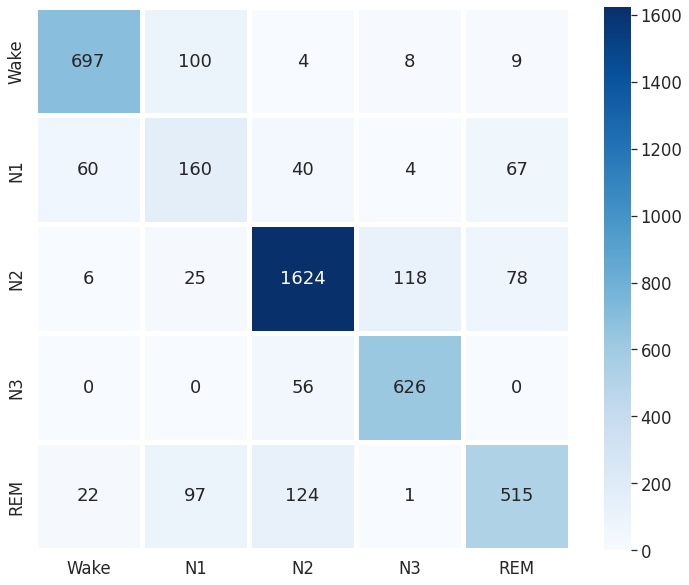

In [343]:
plot_confusion_matrix(true_labels, pred_labels, "")

## 使用focal loss训练

In [354]:
class focal_loss(nn.Module):
    def __init__(self, alpha= 0.25 , gamma=2, num_classes = 5, size_average=True):
        """
        focal_loss损失函数, -α(1-yi)**γ *ce_loss(xi,yi)
        步骤详细的实现了 focal_loss损失函数.
        :param alpha: 阿尔法α,类别权重.      
                    当α是列表时,为各类别权重；
                    当α为常数时,类别权重为[α, 1-α, 1-α, ....],
                    常用于目标检测算法中抑制背景类, 
                    retainnet中设置为0.25
        :param gamma: 伽马γ,难易样本调节参数. retainnet中设置为2
        :param num_classes: 类别数量
        :param size_average: 损失计算方式,默认取均值
        """
        super(focal_loss,self).__init__()
        self.size_average = size_average
        if isinstance(alpha,list):
            assert len(alpha)==num_classes   
            # α可以以list方式输入,
            # size:[num_classes] 用于对不同类别精细地赋予权重
            print("Focal_loss alpha = {}, 将对每一类权重进行精细化赋值".format(alpha))
            self.alpha = torch.Tensor(alpha)
        else:
            assert alpha<1  #如果α为一个常数,则降低第一类的影响,在目标检测中为第一类
            print("Focal_loss alpha = {} ,将对背景类进行衰减,请在目标检测任务中使用.".format(alpha))
            self.alpha = torch.zeros(num_classes)
            self.alpha[0] += alpha
            self.alpha[1:] += (1-alpha) # α 最终为 [ α, 1-α, 1-α, 1-α, 1-α, ...] size:[num_classes]

        self.gamma = gamma

    def forward(self, preds, labels):
        """
        focal_loss损失计算
        :param preds: 预测类别. size:[B,N,C] or [B,C]    分
                别对应与检测与分类任务, B 批次, N检测框数, C类别数
        :param labels:  实际类别. size:[B,N] or [B]
        :return:
        """
        # assert preds.dim()==2 and labels.dim()==1
        preds = preds.view(-1,preds.size(-1))
        self.alpha = self.alpha.to(preds.device)
        # 这里并没有直接使用log_softmax, 因为后面会用到softmax的结果(当然也可以使用log_softmax,然后进行exp操作)
        preds_softmax = F.softmax(preds, dim=1)
        # 对所求概率进行 clamp 操作，不然当某一概率过小时，进行 log 操作，会使得 loss 变为 nan!!!
        preds_softmax = preds_softmax.clamp(min=0.0001, max=1.0)
        preds_logsoft = torch.log(preds_softmax)
                
        # 这部分实现nll_loss ( crossempty = log_softmax + nll )
        preds_softmax = preds_softmax.gather(1,labels.view(-1,1))   
        preds_logsoft = preds_logsoft.gather(1,labels.view(-1,1))
        alpha = self.alpha.gather(0,labels.view(-1))
        loss = -torch.mul(torch.pow((1-preds_softmax), self.gamma), preds_logsoft)  
        # torch.pow((1-preds_softmax), self.gamma) 为focal loss中 (1-pt)**γ

        loss = torch.mul(alpha, loss.t())
        if self.size_average:
            loss = loss.mean()
        else:
            loss = loss.sum()
        return loss

In [355]:
criterion = focal_loss() # 损失函数
save_path = "./Model/" + model_t_name + '_weights_' + str(LEARNING_RATE) + '_' + 'focalloss'+ '2' + '.pt'

Focal_loss alpha = [0.16, 0.4, 0.08, 0.19, 0.17], 将对每一类权重进行精细化赋值


In [368]:
nums = [818, 331, 1851, 682, 759]
w = [ (sum(nums) / num) for num in nums]
w = [ _ / sum(w) for _ in w]
w

[0.16154123967829093,
 0.3992167192049607,
 0.07138883525491194,
 0.1937547420188299,
 0.17409846384300656]

In [369]:
criterion = focal_loss(alpha = w)

Focal_loss alpha = [0.16154123967829093, 0.3992167192049607, 0.07138883525491194, 0.1937547420188299, 0.17409846384300656], 将对每一类权重进行精细化赋值


In [356]:
# [0.16, 0.4, 0.08, 0.19, 0.17] 时
t_train_losses, t_test_losses, t_train_accuracies, t_test_accuracies = train_model(
      model = model_t, 
      train_loader = T_train_loader, 
      test_loader = T_test_loader, 
      optimizer = optimizer, 
      criterion = criterion, 
      epochs = EPOCHS, 
      device = DEVICE,
      save_path = save_path
      )

clear_output(wait=True)

Epoch: 59/60 	 Train Loss: 0.022234 	 Test Loss: 0.037331 	 Train Accuracy: 0.8560 	 Test Accuracy: 0.8140
Model improved - Saving Model


In [371]:
# 特异性
from torchmetrics import Specificity

test_spc_en = Specificity(num_classes=5, threshold=1. / 5, average="macro") # Specificity
print(test_spc_en(torch.tensor(pred_labels), torch.tensor(true_labels)))

tensor(0.9527)


In [370]:
# [0.15, 0.44, 0.07, 0.18, 0.16]

t_train_losses, t_test_losses, t_train_accuracies, t_test_accuracies = train_model(
      model = model_t, 
      train_loader = T_train_loader, 
      test_loader = T_test_loader, 
      optimizer = optimizer, 
      criterion = criterion, 
      epochs = EPOCHS, 
      device = DEVICE,
      save_path = save_path
      )

clear_output(wait=True)

Epoch: 59/60 	 Train Loss: 0.001489 	 Test Loss: 0.123285 	 Train Accuracy: 0.9907 	 Test Accuracy: 0.7814


In [357]:
model_test = ZCY_EEGNet_T()
model_test.eval()
model_test.load_state_dict(torch.load("./Model/ZCY_EEGNet_T_weights_0.0001_focalloss.pt"))
avg_test_loss, avg_test_acc, true_labels, pred_labels = test_model(model_test, T_test_loader, criterion, DEVICE)

print(classification_report(true_labels, pred_labels, target_names=LABELS))

              precision    recall  f1-score   support

        Wake       0.93      0.83      0.88       818
          N1       0.42      0.58      0.49       331
          N2       0.90      0.83      0.86      1851
          N3       0.84      0.93      0.88       682
         REM       0.73      0.76      0.74       759

    accuracy                           0.81      4441
   macro avg       0.76      0.79      0.77      4441
weighted avg       0.83      0.81      0.82      4441



# 调用模块

In [2]:
#模块调用，小波变换降噪
import numpy as np
import math
import pywt


#封装成函数
def sgn(num):
    if (num > 0):
        return 1.0
    elif (num == 0):
        return 0.0
    else:
        return -1.0


def wavelet_noising(new_df):
    data = new_df.squeeze()
    data = data.tolist()  # 将np.ndarray()转为列表
#     data = data.values.T.tolist()  # 将np.ndarray()转为列表
    w = pywt.Wavelet('sym8')
    # [ca3, cd3, cd2, cd1] = pywt.wavedec(data, w, level=3)  # 分解波
    [ca5, cd5, cd4, cd3, cd2, cd1] = pywt.wavedec(data, w, level=5)  # 分解波

    length1 = len(cd1)
    length0 = len(data)

    Cd1 = np.array(cd1)
    abs_cd1 = np.abs(Cd1)
    median_cd1 = np.median(abs_cd1)

    sigma = (1.0 / 0.6745) * median_cd1
    lamda = sigma * math.sqrt(2.0 * math.log(float(length0), math.e))
    usecoeffs = []
    usecoeffs.append(ca5)  # 向列表末尾添加对象

    #软硬阈值折中的方法
    a = 0.5

    for k in range(length1):
        if (abs(cd1[k]) >= lamda):
            cd1[k] = sgn(cd1[k]) * (abs(cd1[k]) - a * lamda)
        else:
            cd1[k] = 0.0

    length2 = len(cd2)
    for k in range(length2):
        if (abs(cd2[k]) >= lamda):
            cd2[k] = sgn(cd2[k]) * (abs(cd2[k]) - a * lamda)
        else:
            cd2[k] = 0.0

    length3 = len(cd3)
    for k in range(length3):
        if (abs(cd3[k]) >= lamda):
            cd3[k] = sgn(cd3[k]) * (abs(cd3[k]) - a * lamda)
        else:
            cd3[k] = 0.0

    length4 = len(cd4)
    for k in range(length4):
        if (abs(cd4[k]) >= lamda):
            cd4[k] = sgn(cd4[k]) * (abs(cd4[k]) - a * lamda)
        else:
            cd4[k] = 0.0

    length5 = len(cd5)
    for k in range(length5):
        if (abs(cd5[k]) >= lamda):
            cd5[k] = sgn(cd5[k]) * (abs(cd5[k]) - a * lamda)
        else:
            cd5[k] = 0.0

    usecoeffs.append(cd5)
    usecoeffs.append(cd4)
    usecoeffs.append(cd3)
    usecoeffs.append(cd2)
    usecoeffs.append(cd1)
    recoeffs = pywt.waverec(usecoeffs, w)
    return recoeffs


# def denoise(x, data):
#     data_denoising = wavelet_noising(data)  #调用小波去噪函数
#     return (x, data_denoising)

def denoise(data):
    data_denoising = wavelet_noising(data)  #调用小波去噪函数
    return data_denoising